In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

import dagshub
import mlflow
import mlflow.sklearn

conn = sqlite3.connect('BNBListings.db')
df = pd.read_sql('''SELECT LS.PRICE,LS.ID,LS.HOST_ID,HST.NUMBER_OF_LISTINGS,LS.NEIGHBOURHOOD_ID,NGH.NEIGHBOURHOOD,
                    NGH.NEIGHBOURHOOD_GROUP,LS.ROOM_TYPE,LS.MIN_NIGHTS,LS.NUMBER_OF_REVIEWS,LS.REVIEWS_PER_MONTH,
                    LS.PER_YEAR_AVAILABILITY
                    FROM LISTINGS LS
                    JOIN NEIGHBOURHOOD NGH ON LS.NEIGHBOURHOOD_ID = NGH.NEIGHBOURHOOD_ID
                    JOIN HOST HST ON LS.HOST_ID = HST.HOST_ID''',conn)
conn.close()
df

,PRICE,ID,HOST_ID,NUMBER_OF_LISTINGS,NEIGHBOURHOOD_ID,NEIGHBOURHOOD,NEIGHBOURHOOD_GROUP,ROOM_TYPE,MIN_NIGHTS,NUMBER_OF_REVIEWS,REVIEWS_PER_MONTH,PER_YEAR_AVAILABILITY
0,149,2539,2787,6,108,Kensington,Brooklyn,Private room,1,9,0.21,365
1,225,2595,2845,2,127,Midtown,Manhattan,Entire home/apt,1,45,0.38,355
2,89,3831,4869,1,41,Clinton Hill,Brooklyn,Entire home/apt,1,270,4.64,194
3,80,5022,7192,1,61,East Harlem,Manhattan,Entire home/apt,10,9,0.10,0
4,200,5099,7322,1,137,Murray Hill,Manhattan,Entire home/apt,3,74,0.59,129
...,...,...,...,...,...,...,...,...,...,...,...,...
38807,129,36425863,83554966,1,201,Upper East Side,Manhattan,Private room,1,1,1.00,147
38808,45,36427429,257683179,6,77,Flushing,Queens,Private room,1,1,1.00,339
38809,235,36438336,211644523,1,90,Great Kills,Staten Island,Private room,1,1,1.00,87
38810,100,36442252,273841667,1,134,Mott Haven,Bronx,Entire home/apt,1,2,2.00,40


Dropping ID,HOST_ID,NEIGHBOURHOOD columns as they have no use for the model

In [9]:
model = df.drop(columns = ['ID','HOST_ID','NEIGHBOURHOOD'])
model

,PRICE,NUMBER_OF_LISTINGS,NEIGHBOURHOOD_ID,NEIGHBOURHOOD_GROUP,ROOM_TYPE,MIN_NIGHTS,NUMBER_OF_REVIEWS,REVIEWS_PER_MONTH,PER_YEAR_AVAILABILITY
0,149,6,108,Brooklyn,Private room,1,9,0.21,365
1,225,2,127,Manhattan,Entire home/apt,1,45,0.38,355
2,89,1,41,Brooklyn,Entire home/apt,1,270,4.64,194
3,80,1,61,Manhattan,Entire home/apt,10,9,0.10,0
4,200,1,137,Manhattan,Entire home/apt,3,74,0.59,129
...,...,...,...,...,...,...,...,...,...
38807,129,1,201,Manhattan,Private room,1,1,1.00,147
38808,45,6,77,Queens,Private room,1,1,1.00,339
38809,235,1,90,Staten Island,Private room,1,1,1.00,87
38810,100,1,134,Bronx,Entire home/apt,1,2,2.00,40


Analysing number of nulls in the data

In [31]:
model.isna().sum()

PRICE                    0
NUMBER_OF_LISTINGS       0
NEIGHBOURHOOD_ID         0
NEIGHBOURHOOD_GROUP      0
ROOM_TYPE                0
MIN_NIGHTS               0
NUMBER_OF_REVIEWS        0
REVIEWS_PER_MONTH        0
PER_YEAR_AVAILABILITY    0
dtype: int64

Converting categorical variables to categorical data type

In [38]:
neighbourhood_groups = model['NEIGHBOURHOOD_GROUP'].astype("category").cat.categories
for original_value, code in zip(neighbourhood_groups, range(len(neighbourhood_groups))):
    print(f"Original Value: {original_value} | Code: {code}")

Original Value: Bronx | Code: 0
Original Value: Brooklyn | Code: 1
Original Value: Manhattan | Code: 2
Original Value: Queens | Code: 3
Original Value: Staten Island | Code: 4


In [39]:
room_types = model['ROOM_TYPE'].astype("category").cat.categories
for original_value, code in zip(room_types, range(len(room_types))):
    print(f"Original Value: {original_value} | Code: {code}")

Original Value: Entire home/apt | Code: 0
Original Value: Private room | Code: 1
Original Value: Shared room | Code: 2


In [64]:
model['NEIGHBOURHOOD_GROUP'] = model['NEIGHBOURHOOD_GROUP'].astype("category")
model['ROOM_TYPE'] = model['ROOM_TYPE'].astype("category")
model['NEIGHBOURHOOD_ID'] = model['NEIGHBOURHOOD_ID'].astype("category")
model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38812 entries, 0 to 38811
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   PRICE                  38812 non-null  int64   
 1   NUMBER_OF_LISTINGS     38812 non-null  int64   
 2   NEIGHBOURHOOD_ID       38812 non-null  category
 3   NEIGHBOURHOOD_GROUP    38812 non-null  category
 4   ROOM_TYPE              38812 non-null  category
 5   MIN_NIGHTS             38812 non-null  int64   
 6   NUMBER_OF_REVIEWS      38812 non-null  int64   
 7   REVIEWS_PER_MONTH      38812 non-null  float64 
 8   PER_YEAR_AVAILABILITY  38812 non-null  int64   
dtypes: category(3), float64(1), int64(5)
memory usage: 1.9 MB


Performing train/test split with 20% testing data

In [65]:
model_train,model_test = train_test_split(model, test_size=0.2,random_state=42)
model_train

,PRICE,NUMBER_OF_LISTINGS,NEIGHBOURHOOD_ID,NEIGHBOURHOOD_GROUP,ROOM_TYPE,MIN_NIGHTS,NUMBER_OF_REVIEWS,REVIEWS_PER_MONTH,PER_YEAR_AVAILABILITY
22046,100,1,26,1,1,1,3,1.58,2
16268,65,1,117,3,1,1,5,0.15,66
16307,95,1,13,1,0,4,20,1.81,14
4387,240,1,214,1,0,2,87,1.46,77
19286,100,1,214,1,1,7,1,0.28,365
...,...,...,...,...,...,...,...,...,...
6265,65,2,13,1,1,2,14,0.27,0
11284,70,1,189,3,1,4,4,0.10,25
38158,30,1,51,1,1,1,1,0.88,34
860,219,2,201,2,0,4,102,1.15,280


Drawing a feature correlation heatmap for numerical predictors

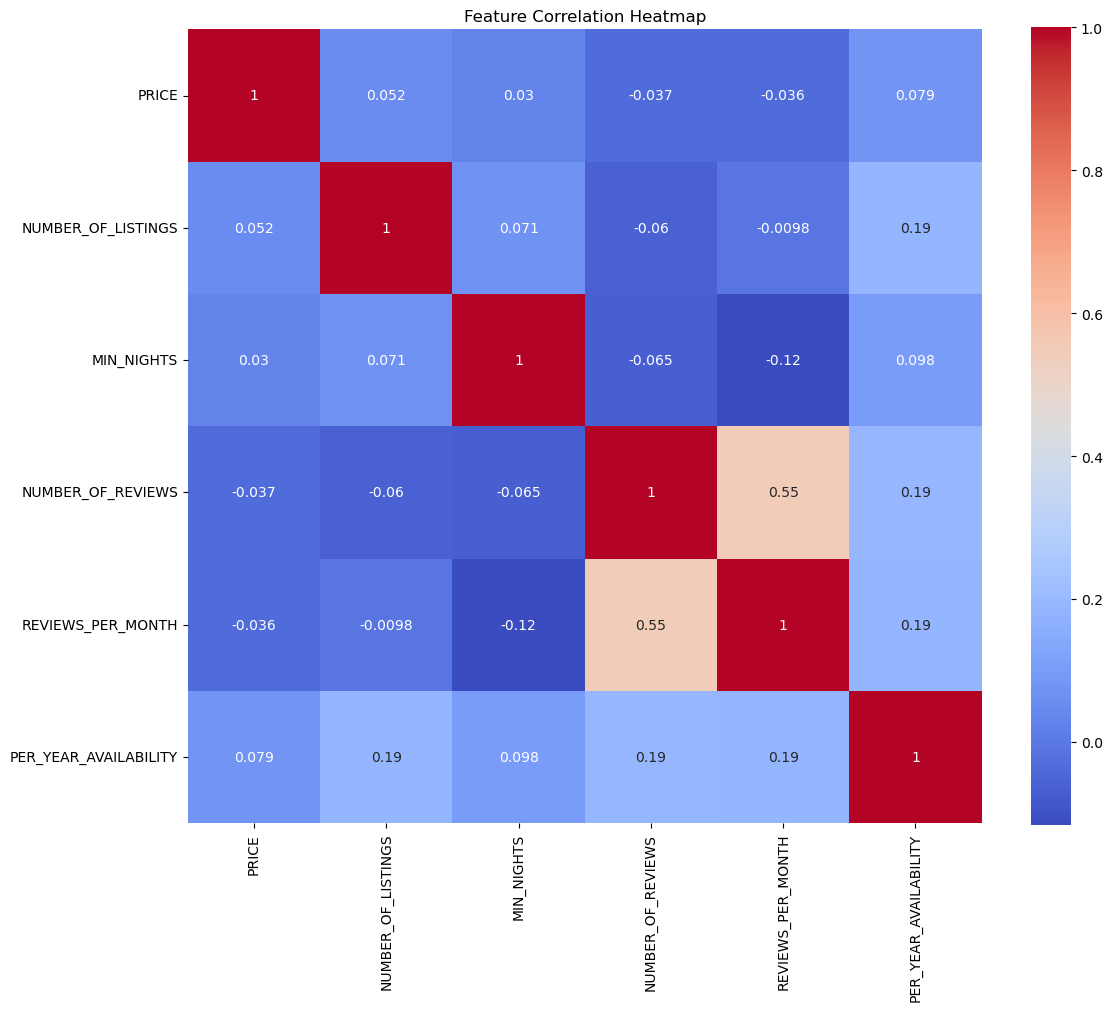

In [66]:
plt.figure(figsize=(12,10))
sns.heatmap(model_train.drop(columns=['NEIGHBOURHOOD_ID','NEIGHBOURHOOD_GROUP','ROOM_TYPE']).corr(),annot=True,cmap='coolwarm'
           ,square=True)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

Drawing a violinplot to understand understand correlation with categorical variables

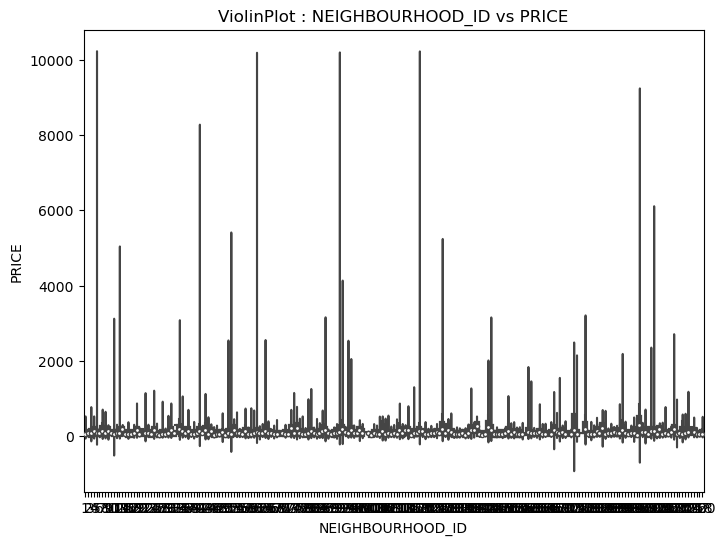

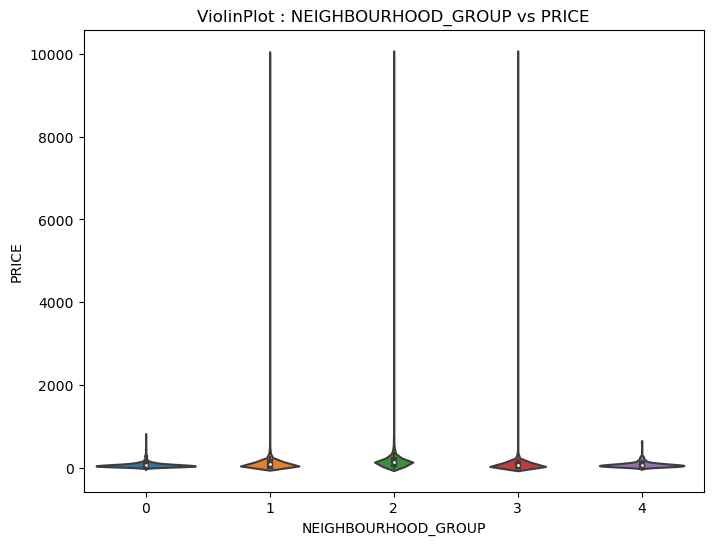

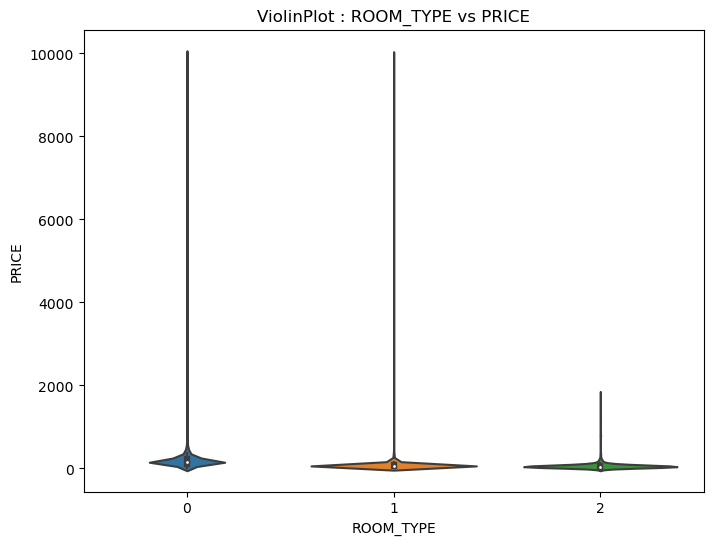

In [73]:
for column in ['NEIGHBOURHOOD_ID','NEIGHBOURHOOD_GROUP','ROOM_TYPE']:
    plt.figure(figsize = (8,6))
    sns.violinplot(x=column,y='PRICE',data=model_train)
    plt.title(f'ViolinPlot : {column} vs PRICE')
    plt.tight_layout
    plt.show()

Plotting a histogram of each column to understand their distributions

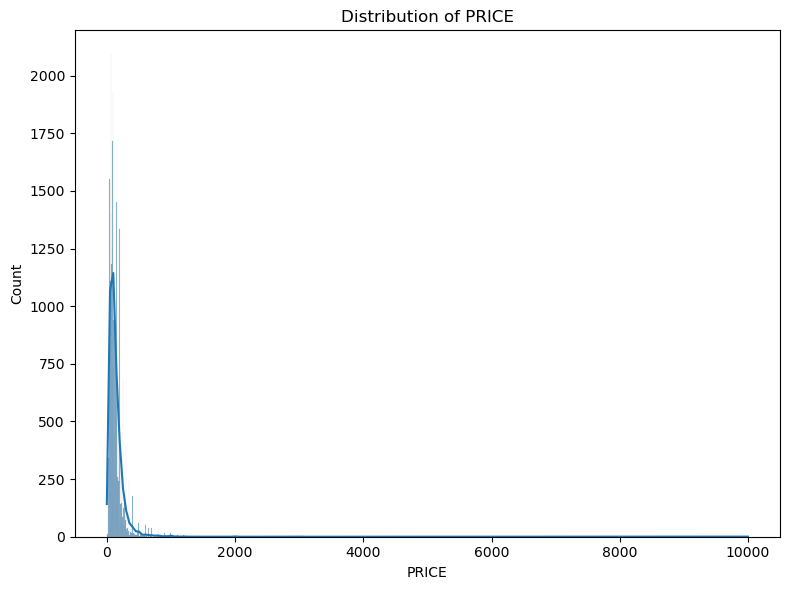

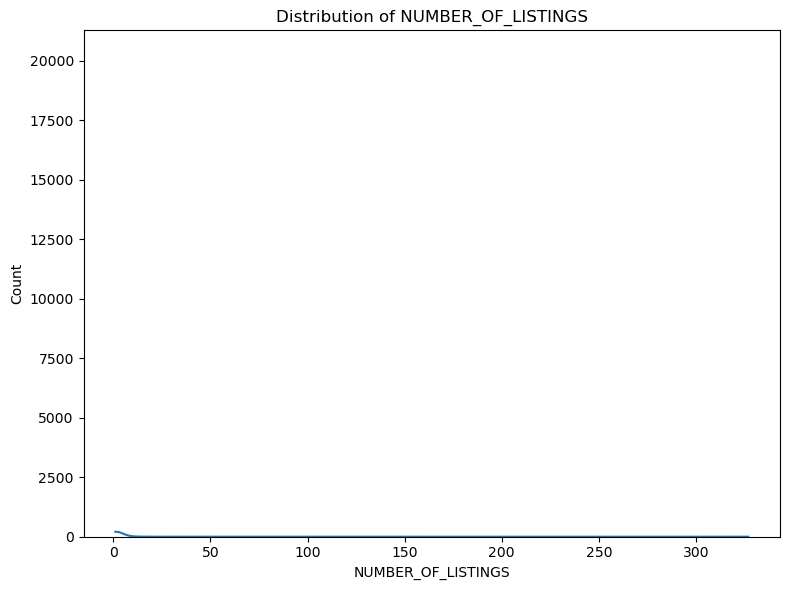

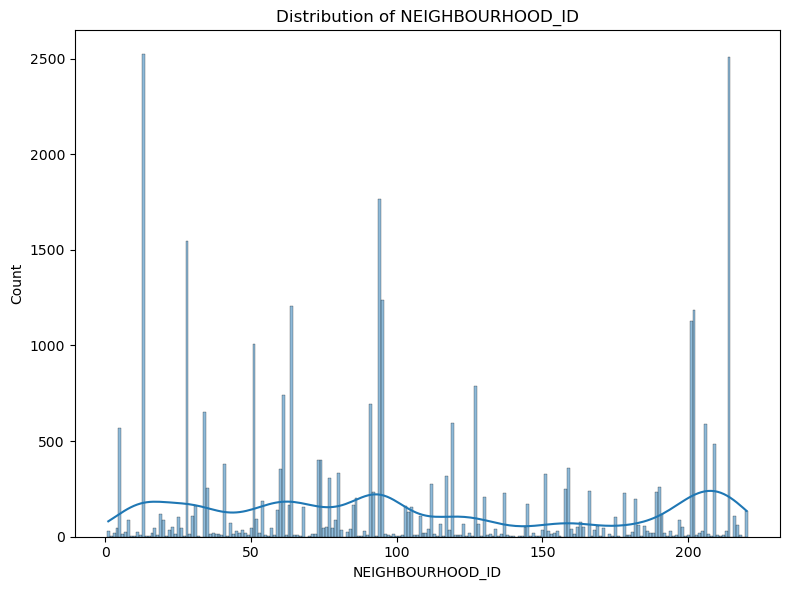

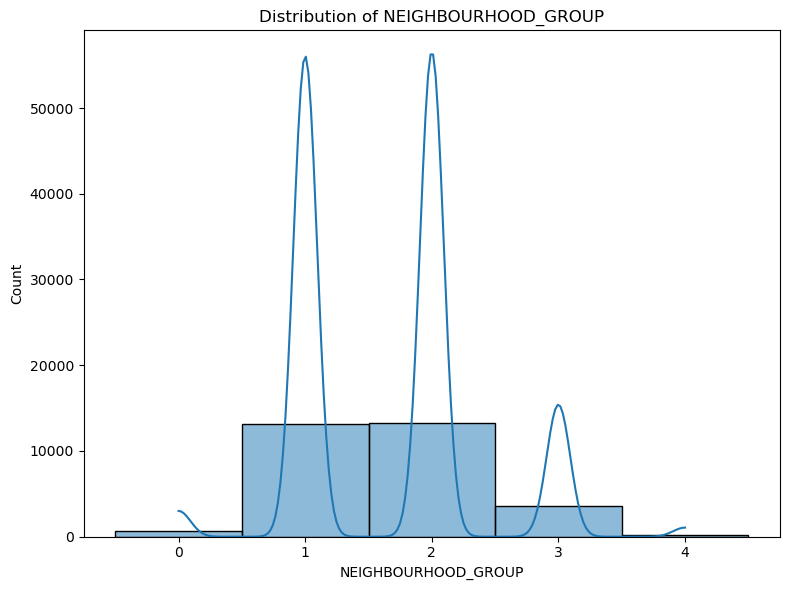

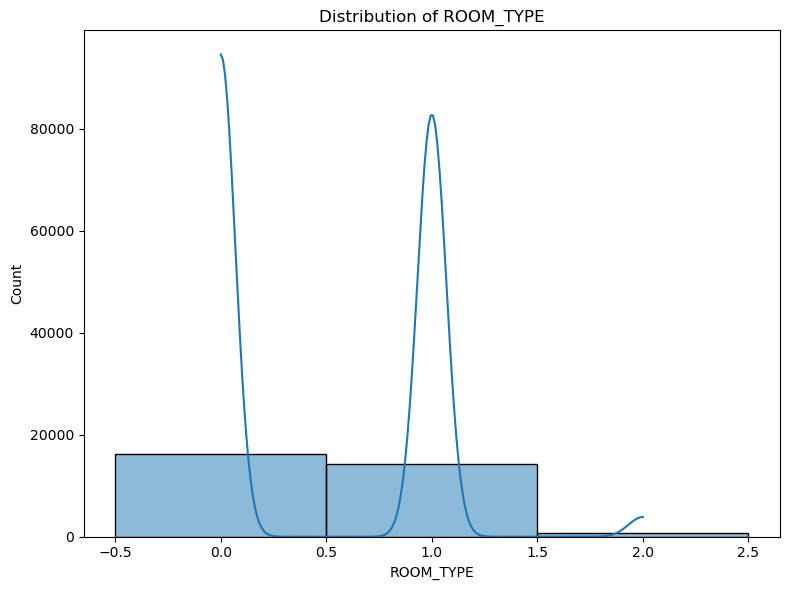

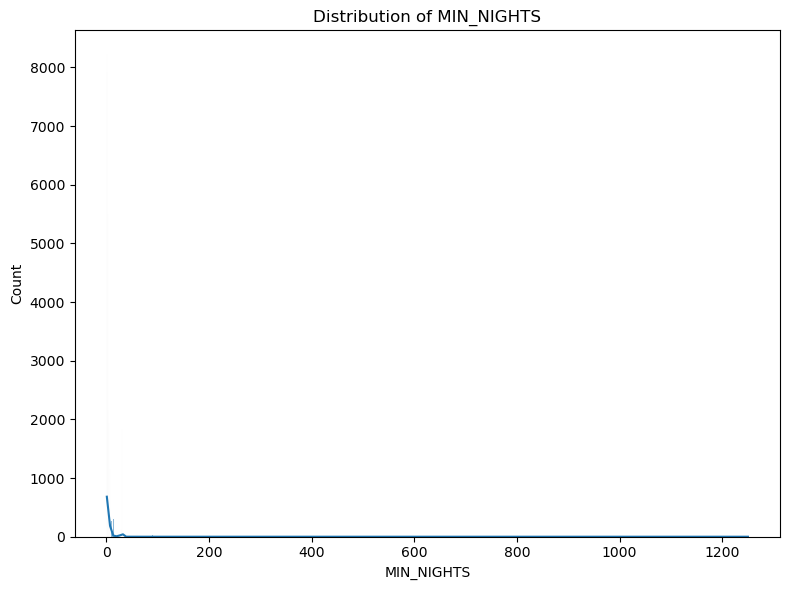

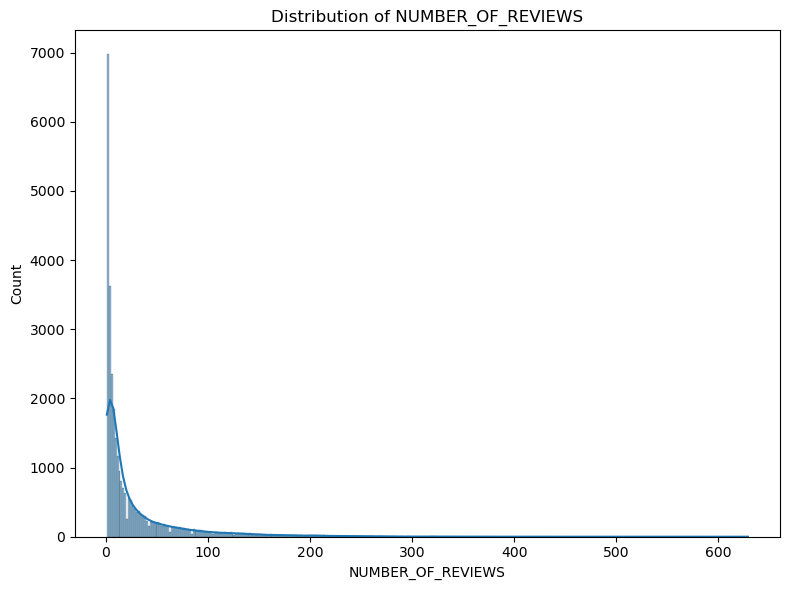

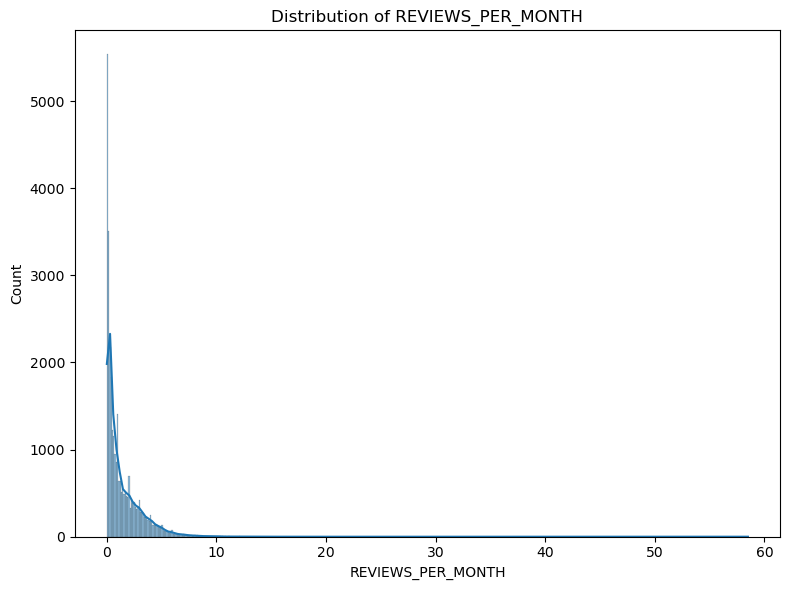

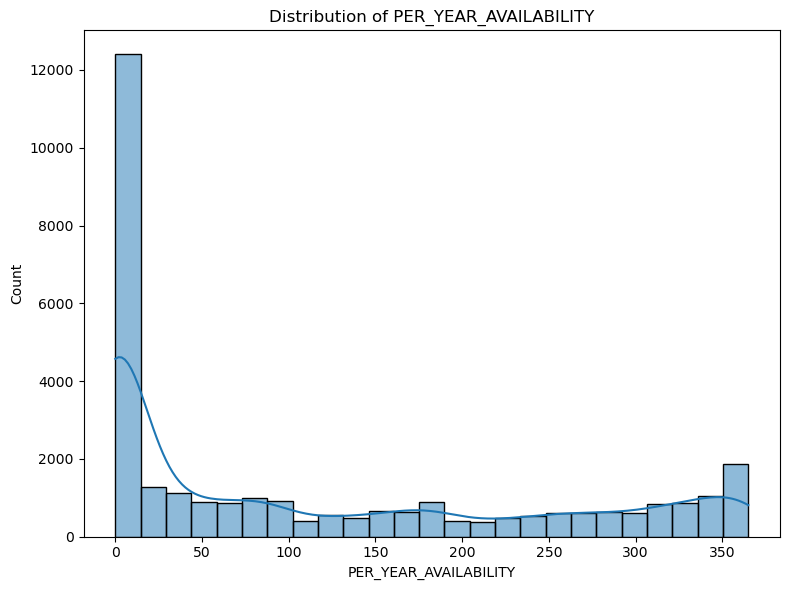

In [75]:
for column in model_train.columns:
    plt.figure(figsize=(8,6))
    sns.histplot(model_train[column],kde=True)
    plt.title(f'Distribution of {column}')
    plt.tight_layout()
    plt.show()

Splitting dataset into predictors and response

In [67]:
x_train = model_train.drop(columns='PRICE')
y_train = model_train['PRICE']
x_test = model_test.drop(columns='PRICE')
y_test = model_test['PRICE']
x_test

,NUMBER_OF_LISTINGS,NEIGHBOURHOOD_ID,NEIGHBOURHOOD_GROUP,ROOM_TYPE,MIN_NIGHTS,NUMBER_OF_REVIEWS,REVIEWS_PER_MONTH,PER_YEAR_AVAILABILITY
32873,1,51,1,0,2,7,1.03,0
13333,2,109,3,2,1,8,0.73,362
1930,1,214,1,1,3,78,1.01,268
26556,1,202,2,0,2,15,1.29,18
16522,8,68,3,1,1,91,2.82,162
...,...,...,...,...,...,...,...,...
30234,1,104,3,0,2,38,4.01,49
17928,2,91,1,0,2,91,3.35,101
10993,1,64,2,1,3,1,0.02,0
28184,1,63,1,2,2,26,2.25,50


Registering our first experiment on Dagshub, with linear regression

In [81]:
dagshub.init("EAS503", "nihumads", mlflow=True)
mlflow.start_run()
mlflow.log_param('fit_intercept',True)
mlflow.log_param('copy_X',False)
mlflow.log_param('positive',False)
mlflow.log_param('n_jobs',4)
LR = LinearRegression(fit_intercept = True,copy_X = False,positive = False,n_jobs = 4)
LR.fit(x_train,y_train)
LR_pred = LR.predict(x_test)
mlflow.log_metric('mean_absolute_error',mean_absolute_error(y_test, LR_pred))
mlflow.log_metric('mean_squared_error',mean_squared_error(y_test, LR_pred))
mlflow.log_metric('root_mean_absolute_error',np.sqrt(mean_squared_error(y_test, LR_pred)))
mlflow.end_run()

Initialized MLflow to track repo "nihumads/EAS503"

Repository nihumads/EAS503 initialized!

Finding the optimal paramters for LR through Grid Search CV

In [82]:
model_LR = LinearRegression()
params = {'fit_intercept':[True,False], 'copy_X':[True, False], 'positive':[True, False], 'n_jobs':range(2, 11)}

## Building Grid Search algorithm with cross-validation and Mean Squared Error score.
grid_search_LR = GridSearchCV(estimator=model_LR,
                              param_grid=params,
                              cv=5, 
                              return_train_score=True)
grid_search_LR.fit(x_train, y_train)
best_parameters_LR = grid_search_LR.best_params_  
best_score_LR = grid_search_LR.best_score_ 
print(best_parameters_LR)
print(best_score_LR)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 2, 'positive': False}
0.10330018480205623


Registering the best LR experiment on Dagshub

In [83]:
mlflow.start_run()
mlflow.log_param('fit_intercept',True)
mlflow.log_param('copy_X',True)
mlflow.log_param('positive',False)
mlflow.log_param('n_jobs',2)
LR = LinearRegression(fit_intercept = True,copy_X = True,positive = False,n_jobs = 2)
LR.fit(x_train,y_train)
LR_pred = LR.predict(x_test)
mlflow.log_metric('mean_absolute_error',mean_absolute_error(y_test, LR_pred))
mlflow.log_metric('mean_squared_error',mean_squared_error(y_test, LR_pred))
mlflow.log_metric('root_mean_absolute_error',np.sqrt(mean_squared_error(y_test, LR_pred)))
mlflow.end_run()

Attempting a decision tree regression and registering it on Dagshub

In [86]:
mlflow.start_run()
mlflow.log_param('max_depth',7)
mlflow.log_param('min_samples_leaf',7)
DT = DecisionTreeRegressor(max_depth = 7,min_samples_leaf = 7)
DT.fit(x_train,y_train)
DT_pred = DT.predict(x_test)
mlflow.log_metric('mean_absolute_error',mean_absolute_error(y_test, DT_pred))
mlflow.log_metric('mean_squared_error',mean_squared_error(y_test, DT_pred))
mlflow.log_metric('root_mean_absolute_error',np.sqrt(mean_squared_error(y_test, DT_pred)))
mlflow.end_run()

Applying Grid Search CV to it to find the best parameters

In [87]:
model_DT = DecisionTreeRegressor()
params = {'max_depth': range(2, 11), 'min_samples_leaf': range(2,11)}
## Building Grid Search algorithm with cross-validation and Mean Squared Error score.
grid_search_DT = GridSearchCV(estimator=model_DT,
                              param_grid=params,
                              cv=5, 
                              return_train_score=True)
grid_search_DT.fit(x_train, y_train)
best_parameters_DT = grid_search_DT.best_params_  
best_score_DT = grid_search_DT.best_score_ 
print(best_parameters_DT)
print(best_score_DT)

{'max_depth': 7, 'min_samples_leaf': 10}
0.13032546999331923


Registering the best DT model on Dagshub

In [88]:
mlflow.start_run()
mlflow.log_param('max_depth',7)
mlflow.log_param('min_samples_leaf',10)
DT = DecisionTreeRegressor(max_depth = 7,min_samples_leaf = 10)
DT.fit(x_train,y_train)
DT_pred = DT.predict(x_test)
mlflow.log_metric('mean_absolute_error',mean_absolute_error(y_test, DT_pred))
mlflow.log_metric('mean_squared_error',mean_squared_error(y_test, DT_pred))
mlflow.log_metric('root_mean_absolute_error',np.sqrt(mean_squared_error(y_test, DT_pred)))
mlflow.end_run()

Finally, registering the model on Dagshub!

In [89]:
with mlflow.start_run() as run:
    mlflow.sklearn.log_model(
    sk_model = DT,
    artifact_path="decisiontree-model",
    input_example = x_train,
    registered_model_name = "decisiontree_cv_selected_model")

C:\Users\nihum\anaconda3\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
C:\Users\nihum\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'decisiontree_cv_selected_model'.
2024